---
# 9. An End-to-End Classification Test
As the last step, you are given a dataset called `data/ccdefault.csv`. The dataset represents default of credit card clients. It has 30,000 cases and 24 different attributes. More details about the dataset is available at `data/ccdefault.txt`. In this task you should make three models, compare their results and conclude the ideal solution. Here are the suggested steps:
1. Load the data.
2. Carry out some exploratory analyses (e.g., how various features and the target variable are distributed).
3. Train a model to predict the target variable (risk of `default`).
  - Employ three different models (logistic regression, decision tree, and random forest).
  - Compare the models' performances (e.g., AUC).
  - Defend your choice of best model (e.g., what are the strength and weaknesses of each of these models?).
4. What more would you do with this data? Anything to help you devise a better solution?

In [54]:
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('lab1').getOrCreate()
df = spark.read.csv('data/ccdefault.csv', header=True, inferSchema=True)
df.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- LIMIT_BAL: integer (nullable = true)
 |-- SEX: integer (nullable = true)
 |-- EDUCATION: integer (nullable = true)
 |-- MARRIAGE: integer (nullable = true)
 |-- AGE: integer (nullable = true)
 |-- PAY_0: integer (nullable = true)
 |-- PAY_2: integer (nullable = true)
 |-- PAY_3: integer (nullable = true)
 |-- PAY_4: integer (nullable = true)
 |-- PAY_5: integer (nullable = true)
 |-- PAY_6: integer (nullable = true)
 |-- BILL_AMT1: integer (nullable = true)
 |-- BILL_AMT2: integer (nullable = true)
 |-- BILL_AMT3: integer (nullable = true)
 |-- BILL_AMT4: integer (nullable = true)
 |-- BILL_AMT5: integer (nullable = true)
 |-- BILL_AMT6: integer (nullable = true)
 |-- PAY_AMT1: integer (nullable = true)
 |-- PAY_AMT2: integer (nullable = true)
 |-- PAY_AMT3: integer (nullable = true)
 |-- PAY_AMT4: integer (nullable = true)
 |-- PAY_AMT5: integer (nullable = true)
 |-- PAY_AMT6: integer (nullable = true)
 |-- DEFAULT: integer (nullable = tru

30000


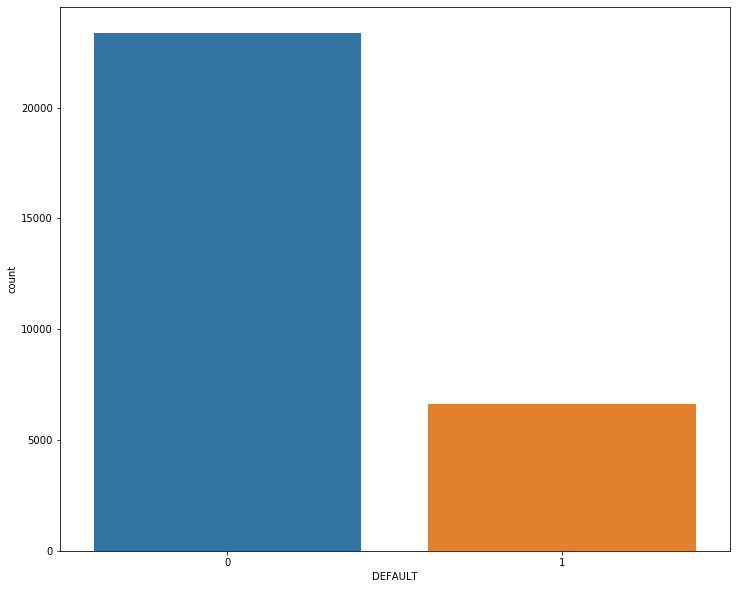

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
df_pd = df.toPandas()
print(len(df_pd))
plt.figure(figsize=(12,10))
sns.countplot(x='DEFAULT', data=df_pd, order=df_pd['DEFAULT'].value_counts().index)

In [25]:
for c in df.columns:
    count = df.filter(df[c].isNull()).count()
    print(f"missing {c} : {count}")        

missing ID : 0
missing LIMIT_BAL : 0
missing SEX : 0
missing EDUCATION : 0
missing MARRIAGE : 0
missing AGE : 0
missing PAY_0 : 0
missing PAY_2 : 0
missing PAY_3 : 0
missing PAY_4 : 0
missing PAY_5 : 0
missing PAY_6 : 0
missing BILL_AMT1 : 0
missing BILL_AMT2 : 0
missing BILL_AMT3 : 0
missing BILL_AMT4 : 0
missing BILL_AMT5 : 0
missing BILL_AMT6 : 0
missing PAY_AMT1 : 0
missing PAY_AMT2 : 0
missing PAY_AMT3 : 0
missing PAY_AMT4 : 0
missing PAY_AMT5 : 0
missing PAY_AMT6 : 0
missing DEFAULT : 0


In [49]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
import pandas as pd
cols = [c for c in df.columns if c != 'DEFAULT' and c != 'ID']
print(cols)
assembler = VectorAssembler(inputCols=cols, outputCol='features')
df_vector = assembler.transform(df).select('features'')

# get correlation matrix
matrix = Correlation.corr(df_vector, 'features')
matrix.collect()[0]["pearson({})".format('features')].values

['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']


array([ 1.00000000e+00,  2.47552351e-02, -2.19160698e-01, -1.08139410e-01,
        1.44712798e-01, -2.71214332e-01, -2.96382101e-01, -2.86122954e-01,
       -2.67460010e-01, -2.49411395e-01, -2.35195399e-01,  2.85429865e-01,
        2.78314364e-01,  2.83235784e-01,  2.93987624e-01,  2.95562338e-01,
        2.90388951e-01,  1.95235915e-01,  1.78407954e-01,  2.10166748e-01,
        2.03242410e-01,  2.17202432e-01,  2.19595369e-01,  2.47552351e-02,
        1.00000000e+00,  1.42319362e-02, -3.13888401e-02, -9.08736465e-02,
       -5.76428789e-02, -7.07710032e-02, -6.60960564e-02, -6.01732384e-02,
       -5.50638850e-02, -4.40077882e-02, -3.36418696e-02, -3.11834722e-02,
       -2.45633117e-02, -2.18796791e-02, -1.70051802e-02, -1.67331263e-02,
       -2.42454563e-04, -1.39090966e-03, -8.59662491e-03, -2.22897151e-03,
       -1.66716180e-03, -2.76602228e-03, -2.19160698e-01,  1.42319362e-02,
        1.00000000e+00, -1.43464340e-01,  1.75060661e-01,  1.05363998e-01,
        1.21565552e-01,  

### Training set and test set

In [127]:
from pyspark.sql.functions import col
from pyspark.ml.feature import StandardScaler

cols = [c for c in df.columns if c != 'DEFAULT' and c != 'ID']

assembler = VectorAssembler(inputCols=cols, outputCol='features')
dataset = assembler.transform(df).select(col('ID'), col('features'), col("DEFAULT").alias("label"))

scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures",
                        withStd=True, withMean=False)

# Compute summary statistics by fitting the StandardScaler
scalerModel = scaler.fit(dataset)

# Normalize each feature to have unit standard deviation.
scaledData = scalerModel.transform(dataset).select(col('ID'), col('features'), col('scaledFeatures'), col("label"))

(trainingSet, testSet) = scaledData.randomSplit([0.8, 0.2], seed=1234)

### Binomial logistic regression

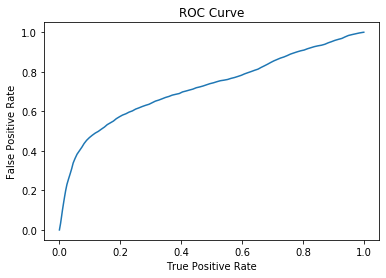

Training set areaUnderROC: 0.7205604129307343


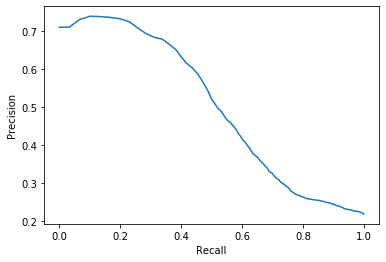

+---+-----+----------+--------------------+--------------------+
| ID|label|prediction|       rawPrediction|         probability|
+---+-----+----------+--------------------+--------------------+
|  1|    1|       0.0|[0.02977334719860...|[0.50744278700153...|
|  2|    1|       0.0|[1.66792712215798...|[0.84129925700928...|
|  3|    0|       0.0|[1.29405260032906...|[0.78483234391105...|
| 14|    1|       0.0|[0.41038790516122...|[0.60118088758094...|
| 27|    1|       0.0|[0.94290310254447...|[0.71968569742891...|
| 28|    0|       0.0|[1.38563042360465...|[0.79989374883822...|
| 32|    1|       0.0|[0.10114030814656...|[0.52526354487869...|
| 35|    0|       0.0|[2.89481826802942...|[0.94758969017980...|
| 42|    0|       0.0|[1.38364242490204...|[0.79957535261267...|
| 45|    0|       0.0|[1.16339542950064...|[0.76194913451658...|
+---+-----+----------+--------------------+--------------------+
only showing top 10 rows

Test set areaUnderROC: 0.7221607965934195


In [128]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics

lr = LogisticRegression(labelCol="label", featuresCol="scaledFeatures",maxIter=10)
lrModel = lr.fit(trainingSet)
trainingSummary = lrModel.summary
train = lrModel.transform(trainingSet)

# Obtain the receiver-operating characteristic as a dataframe and areaUnderROC.
#trainingSummary.roc.show()

roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

## Test
predictions = lrModel.transform(testSet)
predictions.select("ID", "label", "prediction", "rawPrediction", "probability").show(10)
evaluator=BinaryClassificationEvaluator(rawPredictionCol="rawPrediction",labelCol="label")
print("Test set areaUnderROC: " + str(evaluator.evaluate(predictions)))
## error
train_accuracy = evaluator2.evaluate(train)
test_accuracy = evaluator2.evaluate(prediction)
print("Train Error = %g" % (1.0 - train_accuracy))
print("Test Error = %g" % (1.0 - test_accuracy))
# Compute raw scores on the test set
# predictionAndLabels = testSet.rdd.map(lambda lp: (float(lrModel.predict(lp.features)), lp.label))
# predictionAndLabels = prediction.select("rawPrediction", "label").rdd.map(lambda lp: (float(lp.rawPrediction[1]), lp.label[1]))

# Instantiate metrics object
# metrics = BinaryClassificationMetrics(predictionAndLabels)

# Area under ROC curve
# print("Area under ROC = %s" % metrics.areaUnderROC)



### Decision Tree

In [149]:
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

dt = DecisionTreeClassifier(labelCol="label", featuresCol="scaledFeatures",maxDepth=10)
dtModel = dt.fit(trainingSet)

# Train
dt_train = dtModel.transform(trainingSet)
print("Train set areaUnderROC: " + str(evaluator.evaluate(dt_train)))

#Test
dt_predictions = dtModel.transform(testSet)
dt_predictions.select("ID", "label", "prediction", "rawPrediction", "probability").show(10)
evaluator=BinaryClassificationEvaluator(rawPredictionCol="rawPrediction",labelCol="label")
print("Test set areaUnderROC: " + str(evaluator.evaluate(dt_predictions)))

evaluator2=MulticlassClassificationEvaluator(predictionCol="prediction",labelCol="label",metricName="accuracy")

dt_train_accuracy = evaluator2.evaluate(dt_train)
dt_test_accuracy = evaluator2.evaluate(dt_predictions)
print("Train Error = %g" % (1.0 - dt_train_accuracy))
print("Test Error = %g" % (1.0 - dt_test_accuracy))



+---+-----+----------+--------------+--------------------+
| ID|label|prediction| rawPrediction|         probability|
+---+-----+----------+--------------+--------------------+
|  1|    1|       0.0|     [2.0,0.0]|           [1.0,0.0]|
|  2|    1|       0.0|  [181.0,85.0]|[0.68045112781954...|
|  3|    0|       1.0|     [0.0,7.0]|           [0.0,1.0]|
| 14|    1|       1.0|     [6.0,9.0]|           [0.4,0.6]|
| 27|    1|       0.0|[1247.0,280.0]|[0.81663392272429...|
| 28|    0|       0.0|[1247.0,280.0]|[0.81663392272429...|
| 32|    1|       1.0| [179.0,346.0]|[0.34095238095238...|
| 35|    0|       0.0|[7352.0,587.0]|[0.92606121677793...|
| 42|    0|       0.0|[7352.0,587.0]|[0.92606121677793...|
| 45|    0|       0.0|   [25.0,11.0]|[0.69444444444444...|
+---+-----+----------+--------------+--------------------+
only showing top 10 rows

Test set areaUnderROC: 0.416566676827297
Train set areaUnderROC: 0.4092145647179161
Train Error = 0.15088
Test Error = 0.196649


### Random Forest

In [145]:
from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(labelCol="label", featuresCol="scaledFeatures")
rfModel = rf.fit(trainingSet)
# test
rf_predictions = rfModel.transform(testSet)
rf_predictions.select("ID", "label", "prediction", "rawPrediction", "probability").show(10)
evaluator=BinaryClassificationEvaluator(rawPredictionCol="rawPrediction",labelCol="label")
print("Test set areaUnderROC: " + str(evaluator.evaluate(rf_predictions, {evaluator.metricName: "areaUnderROC"})))

rf_train = rfModel.transform(trainingSet)
print("Train set areaUnderROC: " + str(evaluator.evaluate(rf_train, {evaluator.metricName: "areaUnderROC"})))

evaluator2=MulticlassClassificationEvaluator(predictionCol="prediction",labelCol="label",metricName="accuracy")

tf_train_accuracy = evaluator2.evaluate(rf_train)
rf_test_accuracy = evaluator2.evaluate(rf_predictions)
print("Train Error = %g" % (1.0 - tf_train_accuracy))
print("Test Error = %g" % (1.0 - rf_test_accuracy))


+---+-----+----------+--------------------+--------------------+
| ID|label|prediction|       rawPrediction|         probability|
+---+-----+----------+--------------------+--------------------+
|  1|    1|       1.0|[8.28496592795246...|[0.41424829639762...|
|  2|    1|       0.0|[13.0008310657223...|[0.65004155328611...|
|  3|    0|       0.0|[16.8858112021864...|[0.84429056010932...|
| 14|    1|       0.0|[11.6505612142336...|[0.58252806071168...|
| 27|    1|       0.0|[16.1153031655657...|[0.80576515827828...|
| 28|    0|       0.0|[16.8858112021864...|[0.84429056010932...|
| 32|    1|       1.0|[8.83812020458821...|[0.44190601022941...|
| 35|    0|       0.0|[17.5435664791017...|[0.87717832395508...|
| 42|    0|       0.0|[17.4344127545927...|[0.87172063772963...|
| 45|    0|       0.0|[15.4872996627536...|[0.77436498313768...|
+---+-----+----------+--------------------+--------------------+
only showing top 10 rows

Test set areaUnderROC: 0.7569591080813958
Train set areaUnderROC